# Import libraries

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import matplotlib.pyplot as plt
import time

# Instantiate Banana environment

In [2]:
env = UnityEnvironment(file_name="Banana.app") # Update the app name/location if not using macOS

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


# Examine action and state space

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


# Take random actions

In [4]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

# Import agent and take random actions with this agent

In [5]:
from dqn_agent import Agent

In [6]:
agent = Agent(state_size=37, action_size=4, seed=0)      # select an action

In [7]:
env_info = env.reset(train_mode=False)[brain_name]       # reset the environment
state = env_info.vector_observations[0]                  # get the current state
score = 0                                                # initialize the score
while True:
    action = agent.act(state)
    env_info = env.step(action)[brain_name]              # send the action to the environment
    next_state = env_info.vector_observations[0]         # get the next state
    reward = env_info.rewards[0]                         # get the reward
    done = env_info.local_done[0]                        # see if episode has finished
    score += reward                                      # update the score
    state = next_state                                   # roll over the state to next time step
    if done:                                             # exit loop if episode finished
        break
    
print("Score: {}".format(score))

# Learn using Deep Q-Network algorithm

In [8]:
def dqn(n_episodes=2000, max_t=100000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    total_start = time.time()
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    time_episode = 0
    for i_episode in range(1, n_episodes+1):
        start = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        while True:
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        end = time.time()
        time_episode += end - start
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tAverage time required for an episode: {:.1f}s'.format(
                i_episode, np.mean(scores_window), time_episode/100))
            time_episode = 0
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    total_end = time.time()
    
    print('Total time required to solve the environment: {:.1f}s'.format(total_end - total_start))
    return scores

In [9]:
scores = dqn()

Episode 100	Average Score: 0.80	Average time required for an episode: 1.6s
Episode 200	Average Score: 3.85	Average time required for an episode: 1.6s
Episode 300	Average Score: 8.00	Average time required for an episode: 1.6s
Episode 400	Average Score: 11.21	Average time required for an episode: 1.6s
Episode 500	Average Score: 12.77	Average time required for an episode: 1.6s
Episode 511	Average Score: 13.10
Environment solved in 411 episodes!	Average Score: 13.10
Total time required to solve the environment: 829.9s


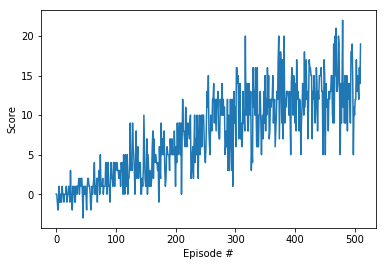

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
env.close()